In [24]:
# import libraries
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
# from pmdarima import auto_arima                              # for determining ARIMA orders
from statsmodels.tsa.stattools import adfuller

# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import time
from datetime import datetime

# Lines below are just to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [25]:
# load and shoe 1st 5 rows of data
df = pd.read_csv('../dataset/full_COA_v3.csv' , index_col='Time',parse_dates=True)
df.head()

,COA,temp,dewPoint,humidity,windSpeed,year,quarter,month,day,weekday_0,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_name,hour_24,weekday_no,weekend_bool,school_vacation
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-01 01:00:00,5986.0,13.98,0.01,0.38,3.09,2012,1,1,1,0,...,0,0,0,0,1,Sunday,1,6,0.0,0.0
2012-01-01 02:00:00,5547.0,11.98,0.99,0.47,2.06,2012,1,1,1,0,...,0,0,0,0,1,Sunday,2,6,0.0,0.0
2012-01-01 03:00:00,5233.0,11.98,0.99,0.47,2.06,2012,1,1,1,0,...,0,0,0,0,1,Sunday,3,6,0.0,0.0
2012-01-01 04:00:00,5150.0,11.98,0.01,0.44,2.06,2012,1,1,1,0,...,0,0,0,0,1,Sunday,4,6,0.0,0.0
2012-01-01 05:00:00,5235.0,11.98,0.01,0.44,3.60,2012,1,1,1,0,...,0,0,0,0,1,Sunday,5,6,0.0,0.0


In [26]:
# subset data set to only ['COA','temp','humidity','windSpeed']
df_l = df[['COA','temp','humidity','windSpeed']]

In [27]:
# resample data to monthly data
df_m = df_l.resample(rule = 'MS').mean()

In [28]:
# change frequancy to daily
df_m.index.freq = 'MS'

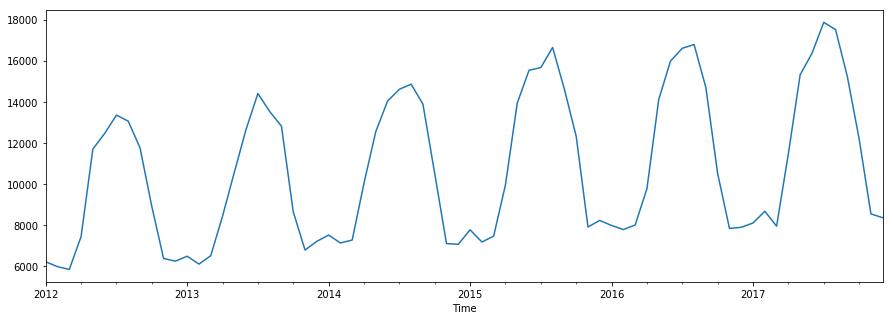

In [29]:
# plot whole data
df_m.COA.plot(figsize=(15,5)).autoscale(axis='x',tight=True)

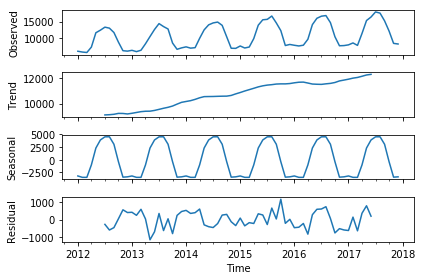

In [30]:
# seasonal decompose
seasonal_decompose(df_m.COA).plot();

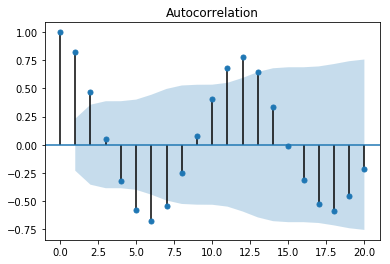

In [31]:
# plot autocorrelation
plot_acf(df_m.COA , lags=20);

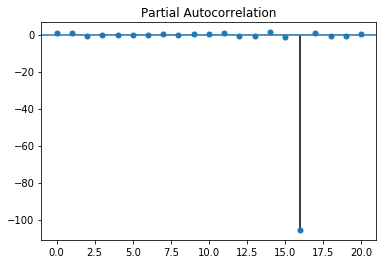

In [32]:
# plot partial autocorrelation
plot_pacf(df_m.COA , lags=20);

In [33]:
# define function for Dickey-Fuller Test 

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [34]:
# doing Dickey-Fuller Test
adf_test(df_m.COA)

Augmented Dickey-Fuller Test: 
ADF test statistic      -0.391346
p-value                  0.911534
# lags used             11.000000
# observations          60.000000
critical value (1%)     -3.544369
critical value (5%)     -2.911073
critical value (10%)    -2.593190
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [35]:
# length to split
l_split = len(df_m['2017-01-01 00:00:00':])

In [36]:
# split by pre defined length
train = df_m.COA.iloc[:(len(df_m)-l_split)]
test = df_m.COA.iloc[(len(df_m)-l_split):]

In [37]:
# define start and end of prediction
start = len(train)
end = len(train) + len(test) - 1

In [38]:
# import statsmodels.api as sm
# import warnings
# import itertools
# # Define the d and q parameters to take any value between 0 and 1
# q = range(0, 5)
# d = range(0, 1)
# # Define the p parameters to take any value between 0 and 3
# p = range(0, 5)

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Define the d and q parameters to take any value between 0 and 1
# Q = range(0, 5)
# D = range(0, 1)
# # Define the p parameters to take any value between 0 and 3
# P = range(0, 5)

# # Generate all different combinations of seasonal p, q and q triplets

# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

# warnings.filterwarnings("ignore") # specify to ignore warning messages
# i = 0
# AIC = []
# SARIMAX_model = []
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             i+=1
#             print('The iteration',i)
#             print('length of pdq',len(pdq)**len(seasonal_pdq))
#             print('length of seasonalpdq',len(seasonal_pdq))
#             mod = sm.tsa.statespace.SARIMAX(train,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             exogenous=exog_to_train,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)

#             results = mod.fit()

#             print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
#             AIC.append(results.aic)
#             SARIMAX_model.append([param, param_seasonal])
#         except:
#             continue

# print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))


In [39]:
# stepwise_model = auto_arima(train,
#                            m=12,
#                             max_p=10,
#                             max_q=10,
#                             max_Q=4,
#                             max_P=5,
#                             max_d=3,
#                             max_D=3,
                            
# #                            start_P=0,D=1,
# #                             seasonal=False,
# #                             exogenous=exog_to_train,
# #                            d=1, 
#                             trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())

In [40]:
# stepwise_model = auto_arima(train,
#                            m=12,
# #                            start_P=0,D=1,
# #                             seasonal=False,
# #                             exogenous=exog_to_train,
# #                            d=1, 
#                             trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())

In [41]:
model = SARIMAX(train,
                                order=(1, 0, 0),
                            seasonal_order=(0, 1, 0, 12),
#                       exogenous=exog_to_train,
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

In [42]:
predictions = model.predict(start=start , end=end).rename('SARIMA(1, 0, 0)(0, 1, 0, 12) Predictions')

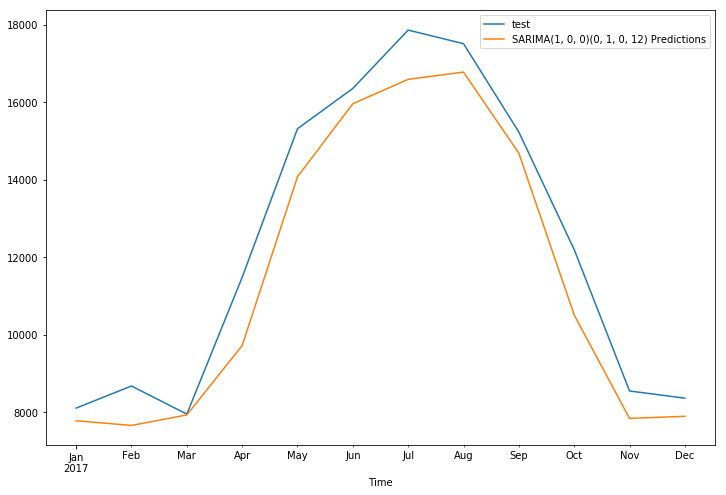

In [43]:
test.rename('test').plot(legend=True,figsize=(12,8))
predictions.plot(legend=True)

In [44]:
rmse(test , predictions)

998.5953264124279

In [45]:
r2_score(test , predictions)

0.9305027393007831